# Definitions
- Definir estações
- Artigo para ler: https://latamt.ieeer9.org/index.php/transactions/article/view/5563
- Plotar hora a hora, e o describe
- Transformação logaritmica, para variacia não constante?
- Método Box-Cox ou deflacionar a série
- Modelar a serie temporal
  - Normality hypothesis tests, Anderson-Darling and Shapiro-Wilk
  - Decompor em 3 partes: tendência, sazonalidade e resíduo
- Aplicar estacionariedade
- Verificar precipitação, quando tiver.
- A press atmo do nivel da estacao ja é a media
- Usar temp. Bulbo seco
- Agrupar por estacoes do ano (verao, inverno, etc)
- Corte as 5h as 21h
- Verificar umidade no litoral
- Pegar estacoes proximas, ir do litoral ao interior
- Pegar principalmente duas regioes (bahia e sul, por exemplo)
- Transfer learning entre estacoes nas regioes


### Manaus

Nesse Notebook, analisaremos os dados da estação A101 (Manaus).

### Imports

In [1]:
%run UtilsNew.ipynb

In [2]:
raw_anual_df = pd.read_csv("data/pelotas.csv", sep=";")

In [3]:
raw_anual_df.head()

,Data,Hora (UTC),Temp. Ins. (C),Temp. Max. (C),Temp. Min. (C),Umi. Ins. (%),Umi. Max. (%),Umi. Min. (%),Pto Orvalho Ins. (C),Pto Orvalho Max. (C),Pto Orvalho Min. (C),Pressao Ins. (hPa),Pressao Max. (hPa),Pressao Min. (hPa),Vel. Vento (m/s),Dir. Vento (m/s),Raj. Vento (m/s),Radiacao (KJ/m²),Chuva (mm)
0,01/01/2024,0,"18,6","19,4","18,6","78,0","79,0","77,0","14,7","15,3","14,6","1015,7","1015,7","1015,4","2,9","95,0","6,6",NaN,"0,0"
1,01/01/2024,100,"18,3","18,6","18,3","78,0","79,0","76,0","14,5","14,6","14,1","1016,0","1016,0","1015,6","3,2","98,0","6,6",NaN,"0,0"
2,01/01/2024,200,"18,1","18,3","18,1","78,0","79,0","76,0","14,3","14,5","14,0","1016,1","1016,2","1016,0","2,2","88,0","5,6",NaN,"0,0"
3,01/01/2024,300,"18,0","18,1","18,0","78,0","80,0","77,0","14,0","14,7","14,0","1016,1","1016,2","1015,9","1,8","67,0","4,6",NaN,"0,0"
4,01/01/2024,400,"17,2","18,0","16,9","81,0","88,0","78,0","14,0","15,2","14,0","1015,8","1016,2","1015,7","1,6","60,0","3,0",NaN,"0,0"


In [4]:
raw_anual_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Data                  8784 non-null   object
 1   Hora (UTC)            8784 non-null   int64 
 2   Temp. Ins. (C)        8722 non-null   object
 3   Temp. Max. (C)        8722 non-null   object
 4   Temp. Min. (C)        8722 non-null   object
 5   Umi. Ins. (%)         8722 non-null   object
 6   Umi. Max. (%)         8722 non-null   object
 7   Umi. Min. (%)         8722 non-null   object
 8   Pto Orvalho Ins. (C)  8722 non-null   object
 9   Pto Orvalho Max. (C)  8722 non-null   object
 10  Pto Orvalho Min. (C)  8722 non-null   object
 11  Pressao Ins. (hPa)    8722 non-null   object
 12  Pressao Max. (hPa)    8722 non-null   object
 13  Pressao Min. (hPa)    8722 non-null   object
 14  Vel. Vento (m/s)      8713 non-null   object
 15  Dir. Vento (m/s)      8713 non-null   

O dataset original precsa de alguns tratamentos. Além disso, a quantidade de registros nulos da radiação é considerável.

### Pre processamento

In [5]:
df = pre_processing(raw_anual_df)

set_plot_size(11, 5)

numeric_cols = ['float16', 'float32', 'float64']

### Corte de horário

In [6]:
df = filter_between(df, "hora", 10, 21)

### Séries Temporais

#### Estacionariedade

Aqui foi feito um resample para agrupar a série por dia, só para termos uma ideia do comportamento diário ao longo do ano. 

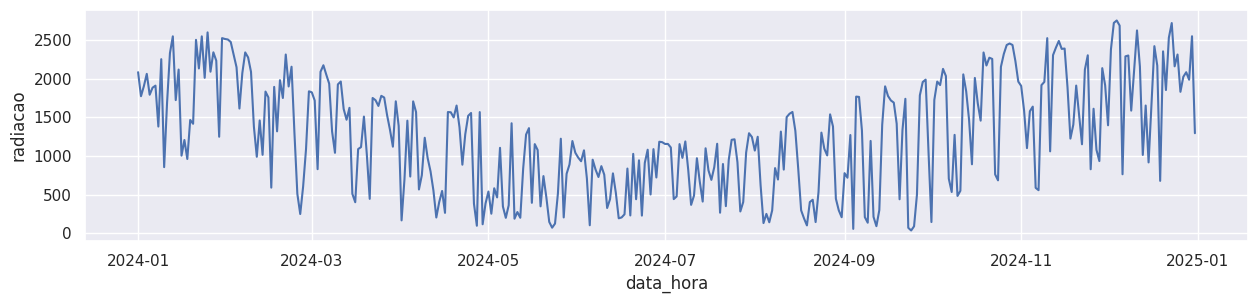

In [7]:
set_plot_size(15, 3)

anual_df_resampled = df[["radiacao", "data_hora"]].set_index("data_hora").resample("D").mean()
plot = sns.lineplot(data=anual_df_resampled, x="data_hora", y="radiacao")

A série horária (original)

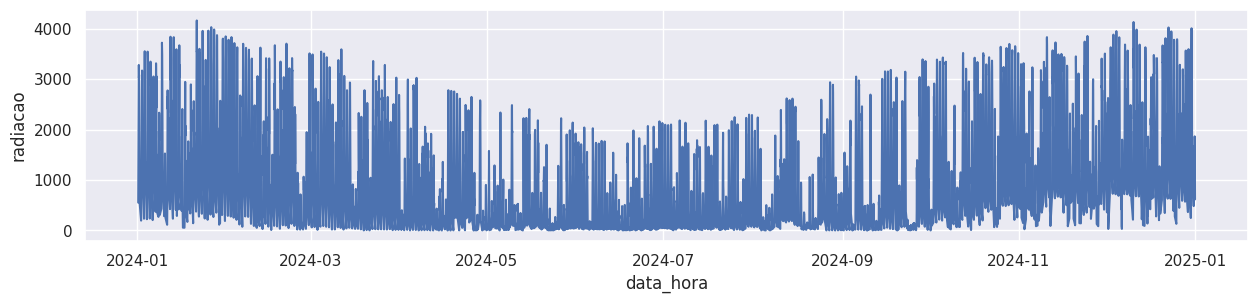

In [8]:
plot = sns.lineplot(data=df[["radiacao", "data_hora"]].set_index("data_hora"), x="data_hora", y="radiacao")

Aplicando o teste AdFuller

In [9]:
def adfuller_test(df):
    result=ts.adfuller(df)
    labels = ['Teste estatístico ADF','p-valor','Num Lags','Numero de observações']
    for value, label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.")
    else:
        print("Fracas evidências contra a hipotese nula(Ho), a série temporal possui uma raíz unitária, indicando que é não estacionária.")


In [10]:
adfuller_test(df[["radiacao", "data_hora"]].set_index("data_hora"))

Teste estatístico ADF : -6.538611943953883
p-valor : 9.469934588161064e-09
Num Lags : 26
Numero de observações : 4237
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


#### Decomposição

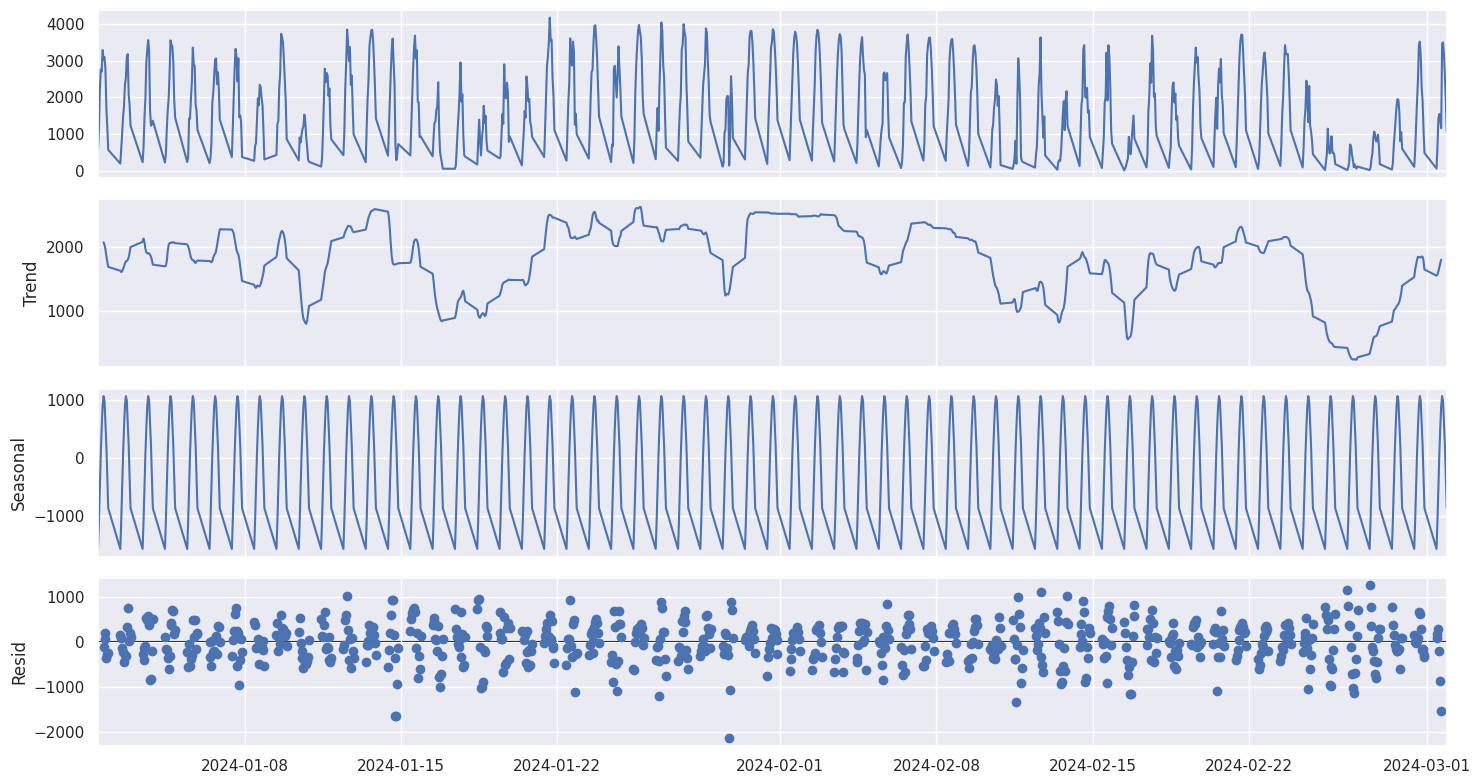

In [11]:
set_plot_size(15, 8)
df_test = filter_between(df, "data", "2024-01-01", "2024-03-01")
df_test = df_test[["radiacao", "data_hora"]].set_index('data_hora')

# A variancia não muda ao longo do tempo, a sazonalizadade nao acompanha a tendencia, por isso o modelo aditivo
resultado = seasonal_decompose(df_test, model="addictive", period=12)
ax = resultado.plot()

#### ACF e PACF

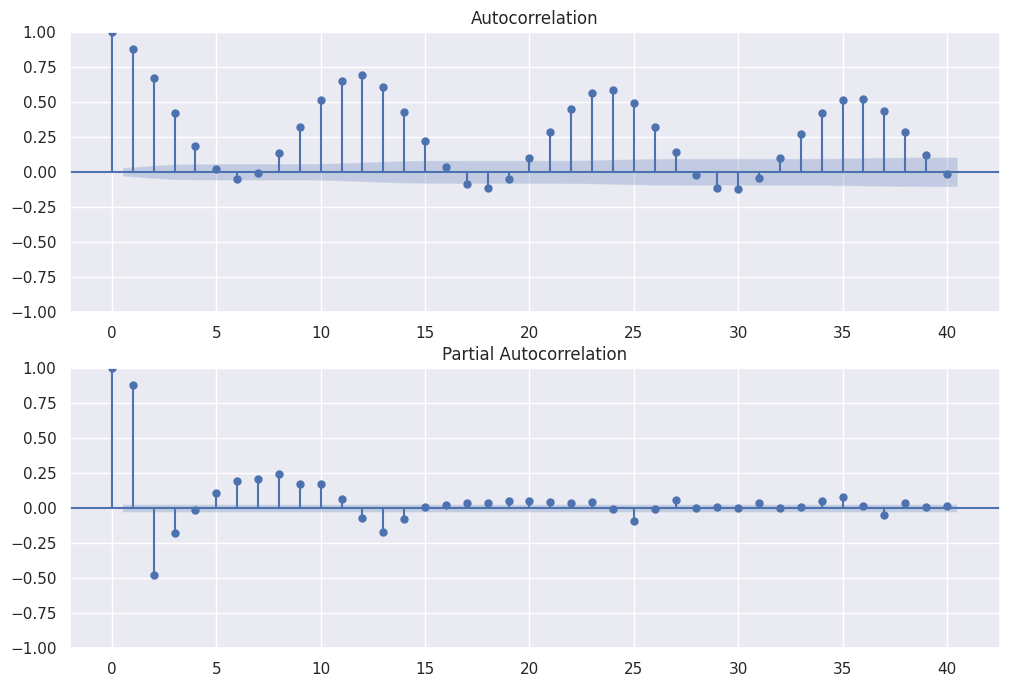

In [12]:
# df_to_model = filter_between(anual_df, "data", "2024-05-01", "2024-10-01")[["data_hora", "radiacao"]].set_index("data_hora")
df_acf_pacf = df[["data_hora", "radiacao"]].set_index("data_hora")

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_acf_pacf,lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_acf_pacf,lags=40, ax=ax2)